# Lambda³ NumPyro Framework - Google Colab Setup

This notebook sets up and tests the Lambda³ NumPyro framework in Google Colab.

## 1. Clone Repository and Install Dependencies

In [1]:
# Clone the repository
!git clone https://github.com/miosync-masa/bayesian-event-detector.git
%cd bayesian-event-detector

Cloning into 'bayesian-event-detector'...
remote: Enumerating objects: 454, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 454 (delta 99), reused 0 (delta 0), pack-reused 296 (from 2)
Receiving objects: 100% (454/454), 699.33 KiB | 6.36 MiB/s, done.
Resolving deltas: 100% (259/259), done.
/content/bayesian-event-detector


In [2]:
# Install required packages
!pip install numpy numba jax jaxlib numpyro arviz pandas scikit-learn matplotlib seaborn networkx yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 8.8 MB/s eta 0:00:00


In [3]:
# Add the lambda3_numpyro directory to Python path
import sys
sys.path.append('/content/bayesian-event-detector')

# Verify JAX installation and GPU availability
import jax
print(f"JAX version: {jax.__version__}")
print(f"JAX backend: {jax.default_backend()}")
print(f"GPU available: {jax.default_backend() == 'gpu'}")

JAX version: 0.5.2
JAX backend: gpu
GPU available: True


## 2. Import Lambda³ Modules

In [7]:
# Import Lambda³ modules
from lambda3_numpyro import (
    L3Config,
    extract_lambda3_features,
    analyze_pair,
    analyze_multiple_series,
    plot_features,
    PLOTTING_AVAILABLE
)

print(f"Lambda³ NumPyro successfully imported!")
print(f"Plotting available: {PLOTTING_AVAILABLE}")

Lambda³ NumPyro successfully imported!
Plotting available: True


## 3. Basic Feature Extraction Test

In [8]:
# Generate synthetic data
import numpy as np

np.random.seed(42)
n_points = 500
t = np.linspace(0, 10*np.pi, n_points)

# Create two correlated series with some jumps
series_a = np.sin(t) + 0.1 * np.random.randn(n_points)
series_b = np.sin(t - 0.5) + 0.1 * np.random.randn(n_points)  # Lagged

# Add jumps
series_a[100] += 3
series_a[300] -= 3
series_b[105] += 3
series_b[305] -= 3

print(f"Generated {n_points} data points for two series")

Generated 500 data points for two series


In [9]:
# Extract features
config = L3Config()
config.bayesian.draws = 1000  # Reduce for faster testing
config.bayesian.tune = 1000
config.bayesian.num_chains = 2

features_a = extract_lambda3_features(series_a, config, series_name='Series_A')
features_b = extract_lambda3_features(series_b, config, series_name='Series_B')

print(f"\nSeries A:")
print(f"  Positive jumps (ΔΛC⁺): {features_a.n_pos_jumps}")
print(f"  Negative jumps (ΔΛC⁻): {features_a.n_neg_jumps}")
print(f"  Mean tension (ρT): {features_a.mean_tension:.3f}")

print(f"\nSeries B:")
print(f"  Positive jumps (ΔΛC⁺): {features_b.n_pos_jumps}")
print(f"  Negative jumps (ΔΛC⁻): {features_b.n_neg_jumps}")
print(f"  Mean tension (ρT): {features_b.mean_tension:.3f}")


Series A:
  Positive jumps (ΔΛC⁺): 7
  Negative jumps (ΔΛC⁻): 8
  Mean tension (ρT): 0.189

Series B:
  Positive jumps (ΔΛC⁺): 7
  Negative jumps (ΔΛC⁻): 8
  Mean tension (ρT): 0.188


## 4. Visualize Features

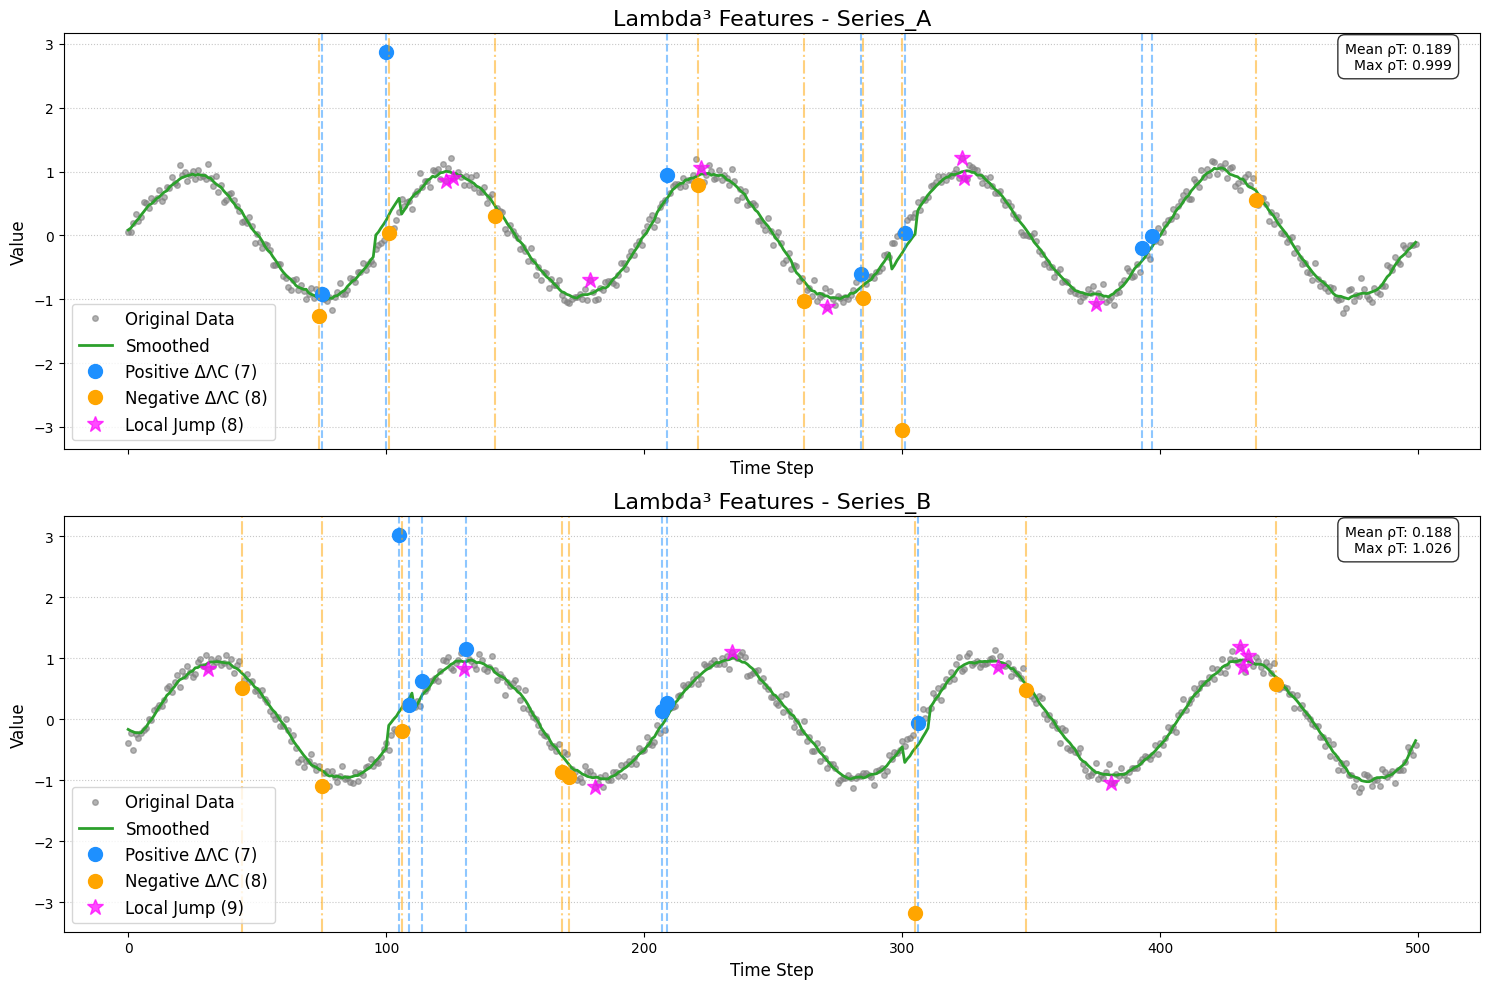

In [10]:
# Plot features
if PLOTTING_AVAILABLE:
    import matplotlib.pyplot as plt

    features_dict = {'Series_A': features_a, 'Series_B': features_b}
    plot_features(features_dict, title="Lambda³ Features")
    plt.show()

## 5. Pairwise Analysis Test

In [ ]:
# Run pairwise analysis
print("Running pairwise analysis...")
results = analyze_pair(
    'Series_A', 'Series_B',
    features_a, features_b,
    config,
    seed=42
)

print(f"\nAnalysis Results:")
print(f"  Max synchronization rate (σₛ): {results.sync_profile.max_sync_rate:.3f}")
print(f"  Optimal lag: {results.sync_profile.optimal_lag}")
print(f"\nInteraction effects:")
for effect, value in results.interaction_effects.items():
    if abs(value) > 0.01:
        print(f"  {effect}: {value:.3f}")

## 6. Test Financial Data Loading

In [5]:
# Load financial data
from lambda3_numpyro import load_financial_data

# Download sample financial data
tickers = {
    "SPY": "SPY",
    "QQQ": "QQQ",
    "DIA": "DIA"
}

print("Downloading financial data...")
financial_data = load_financial_data(
    start_date="2023-01-01",
    end_date="2023-12-31",
    tickers=tickers,
    save_csv=False
)

print(f"\nDownloaded data for: {list(financial_data.keys())}")
for name, data in financial_data.items():
    print(f"  {name}: {len(data)} data points")

Fetching financial data from 2023-01-01 to 2023-12-31...


/content/bayesian-event-detector/lambda3_numpyro/io.py:212: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_list, start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed

Downloaded 250 data points
Series: ['DIA', 'QQQ', 'SPY']

Downloaded data for: ['DIA', 'QQQ', 'SPY']
  DIA: 250 data points
  QQQ: 250 data points
  SPY: 250 data points


## 7. Multi-Series Analysis Test

In [11]:
# Extract features from financial data
from lambda3_numpyro.feature import extract_features_dict

print("Extracting features from financial data...")
financial_features = extract_features_dict(financial_data, config)

# Run cross-analysis
print("\nRunning cross-analysis...")
cross_results = analyze_multiple_series(
    financial_features,
    config,
    show_progress=True
)

print(f"\nCross-Analysis Summary:")
print(f"  Series analyzed: {cross_results.n_series}")
print(f"  Pairs analyzed: {cross_results.n_pairs}")
print(f"  Network density: {cross_results.network_density:.1%}")

Extracting features from financial data...
[1/3] Extracting Lambda³ features for DIA...
  ✓ Length: 250, ΔΛC⁺: 4, ΔΛC⁻: 4, Mean ρT: 3.037
[2/3] Extracting Lambda³ features for QQQ...
  ✓ Length: 250, ΔΛC⁺: 5, ΔΛC⁻: 3, Mean ρT: 4.907
[3/3] Extracting Lambda³ features for SPY...
  ✓ Length: 250, ΔΛC⁺: 5, ΔΛC⁻: 3, Mean ρT: 4.364

Running cross-analysis...

CROSS-SERIES ANALYSIS
Series: DIA, QQQ, SPY
Total pairs: 3

[1/3] Analyzing: DIA ↔ QQQ

Analyzing interaction: DIA ↔ QQQ
  Calculating synchronization profile...
  Fitting Bayesian model for DIA...


/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Running MCMC with 2 chains, 1000 samples each...


sample: 100%|██████████| 2000/2000 [00:33<00:00, 59.59it/s, 15 steps of size 2.43e-01. acc. prob=0.95] 
/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


  ✓ No divergences for DIA
  Fitting Bayesian model for QQQ...
Running MCMC with 2 chains, 1000 samples each...


sample: 100%|██████████| 2000/2000 [00:35<00:00, 56.11it/s, 15 steps of size 2.00e-01. acc. prob=0.97]
/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


  ✓ No divergences for QQQ
  Calculating causality profiles...
  ✓ Sync rate (σₛ): 0.004
  ✓ Primary effect: QQQ_to_DIA_stress
  ✓ Convergence: Good (0 divergences)
  ✓ Sync rate (σₛ): 0.004
  ✓ Primary effect: QQQ_to_DIA_stress

[2/3] Analyzing: DIA ↔ SPY

Analyzing interaction: DIA ↔ SPY
  Calculating synchronization profile...
  Fitting Bayesian model for DIA...
Running MCMC with 2 chains, 1000 samples each...


sample: 100%|██████████| 2000/2000 [00:38<00:00, 52.49it/s, 15 steps of size 1.94e-01. acc. prob=0.96]
/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


  ✓ No divergences for DIA
  Fitting Bayesian model for SPY...
Running MCMC with 2 chains, 1000 samples each...


sample: 100%|██████████| 2000/2000 [00:28<00:00, 69.15it/s, 15 steps of size 2.37e-01. acc. prob=0.96] 
/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


  ✓ No divergences for SPY
  Calculating causality profiles...
  ✓ Sync rate (σₛ): 0.008
  ✓ Primary effect: SPY_to_DIA_stress
  ✓ Convergence: Good (0 divergences)
  ✓ Sync rate (σₛ): 0.008
  ✓ Primary effect: SPY_to_DIA_stress

[3/3] Analyzing: QQQ ↔ SPY

Analyzing interaction: QQQ ↔ SPY
  Calculating synchronization profile...
  Fitting Bayesian model for QQQ...
Running MCMC with 2 chains, 1000 samples each...


sample: 100%|██████████| 2000/2000 [00:37<00:00, 53.48it/s, 31 steps of size 1.84e-01. acc. prob=0.96]
/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


  ✓ No divergences for QQQ
  Fitting Bayesian model for SPY...
Running MCMC with 2 chains, 1000 samples each...


sample: 100%|██████████| 2000/2000 [00:39<00:00, 51.00it/s, 31 steps of size 1.88e-01. acc. prob=0.96]


  ✓ No divergences for SPY
  Calculating causality profiles...
  ✓ Sync rate (σₛ): 0.008
  ✓ Primary effect: QQQ_to_SPY_stress
  ✓ Convergence: Good (0 divergences)
  ✓ Sync rate (σₛ): 0.008
  ✓ Primary effect: QQQ_to_SPY_stress

Building synchronization matrix...
Building synchronization network...

Cross-Analysis Summary:
  Series analyzed: 3
  Pairs analyzed: 3
  Network density: 0.0%


## 8. Visualize Results

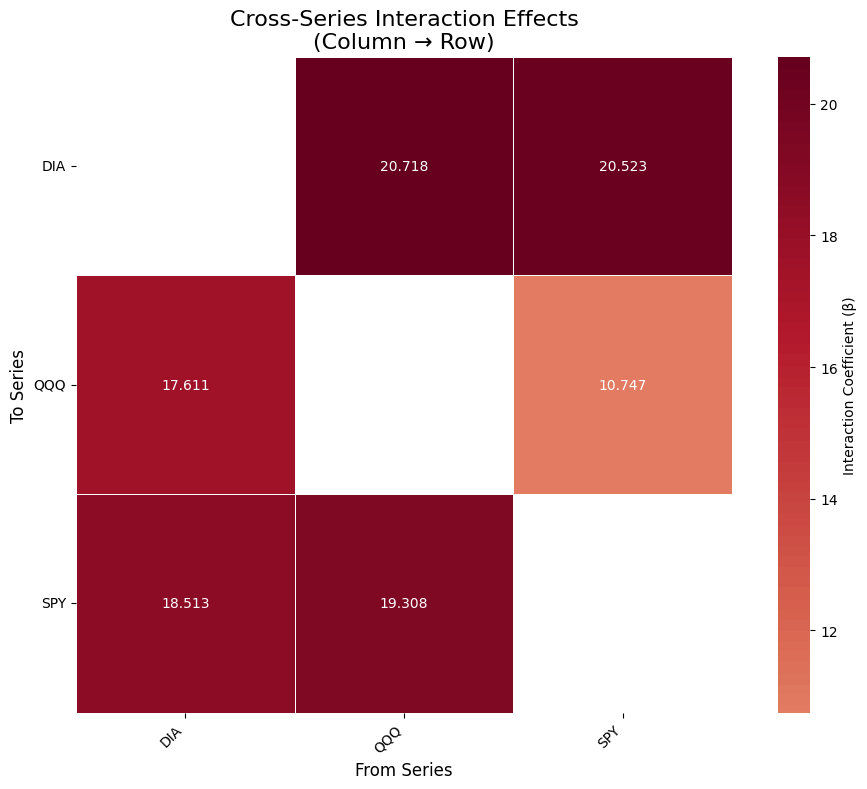

In [13]:
# Plot interaction matrix
if PLOTTING_AVAILABLE:
    from lambda3_numpyro.plot import plot_interaction_matrix

    series_names = cross_results.get_series_names()
    plot_interaction_matrix(
        cross_results.interaction_matrix,
        series_names
    )
    plt.show()

## 9. Run Unit Tests

In [14]:
# Run tests using the command line interface
!cd /content/bayesian-event-detector && python -m lambda3_numpyro.main test --type unit --modules feature


Lambda³ Framework Tests

[UNIT TESTS]

Testing feature module...
  feature: 3/3 passed

TEST SUMMARY
UNIT: 3/3 passed ✓


## 10. Quick Performance Test

Size 100: 0.000 seconds
Size 500: 0.000 seconds
Size 1000: 0.001 seconds
Size 5000: 0.001 seconds


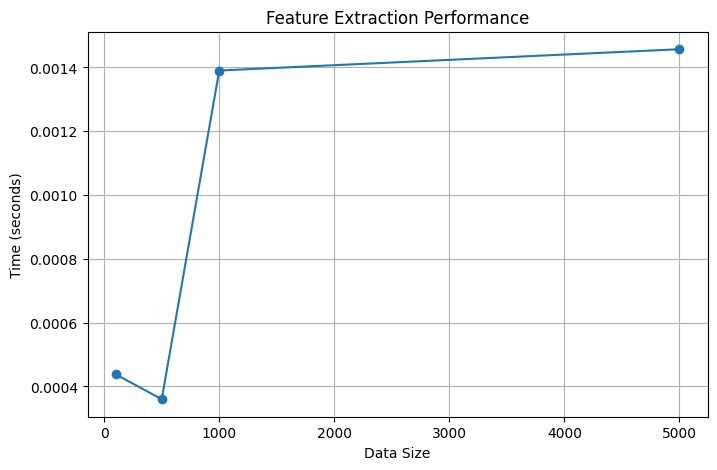

In [15]:
# Test performance with different data sizes
import time

sizes = [100, 500, 1000, 5000]
times = []

for size in sizes:
    data = np.cumsum(np.random.randn(size))

    start = time.time()
    features = extract_lambda3_features(data, config)
    elapsed = time.time() - start

    times.append(elapsed)
    print(f"Size {size}: {elapsed:.3f} seconds")

# Plot performance
if PLOTTING_AVAILABLE:
    plt.figure(figsize=(8, 5))
    plt.plot(sizes, times, 'o-')
    plt.xlabel('Data Size')
    plt.ylabel('Time (seconds)')
    plt.title('Feature Extraction Performance')
    plt.grid(True)
    plt.show()

In [17]:
# ===============================
# Bayesian Inference Test (SVI + LOO/WAIC)
# ===============================

print("="*60)
print("TESTING EXTENDED BAYESIAN INFERENCE")
print("="*60)

# 1. データ準備（金融データの最初の系列を使用）
first_series = list(financial_features.keys())[0]
test_features = financial_features[first_series]

print(f"\nTest series: {first_series}")
print(f"Data length: {len(test_features.data)}")

# 2. Lambda3BayesianInferenceクラスのテスト
from lambda3_numpyro.bayes import Lambda3BayesianInference

# 設定を調整（テスト用に小さく）
test_config = L3Config()
test_config.bayesian.draws = 1000  # 少なめ
test_config.bayesian.tune = 500    # 少なめ
test_config.bayesian.num_chains = 2

# 推論エンジン初期化
print("\n1. Initializing inference engine...")
inference = Lambda3BayesianInference(test_config)

# 3. 各モデルタイプのフィッティング
print("\n2. Fitting models...")

# Base model
print("\n   a) Base model...")
try:
    base_result = inference.fit_model(test_features, model_type='base', seed=42)
    print("   ✓ Base model fitted successfully")
    print(f"   Divergences: {base_result.diagnostics.get('n_divergences', 0)}")
except Exception as e:
    print(f"   ✗ Base model failed: {e}")

# Dynamic model
print("\n   b) Dynamic model...")
try:
    dynamic_result = inference.fit_model(test_features, model_type='dynamic', seed=43)
    print("   ✓ Dynamic model fitted successfully")
    print(f"   Divergences: {dynamic_result.diagnostics.get('n_divergences', 0)}")
except Exception as e:
    print(f"   ✗ Dynamic model failed: {e}")

# SVI model (新機能テスト)
print("\n   c) SVI model (NEW)...")
try:
    svi_result = inference.fit_model(
        test_features,
        model_type='svi',
        n_steps=2000,  # 少なめ
        learning_rate=0.01,
        seed=44
    )
    print("   ✓ SVI model fitted successfully")
    print(f"   Final loss: {svi_result['losses'][-1]:.4f}")
    print(f"   Loss reduction: {svi_result['losses'][0]:.4f} → {svi_result['losses'][-1]:.4f}")
except Exception as e:
    print(f"   ✗ SVI model failed: {e}")

# 4. モデル比較 (LOO-CV) - 新機能テスト
print("\n3. Model comparison with LOO-CV (NEW)...")
try:
    comparison = inference.compare_models(
        test_features,
        criterion='loo',
        include_svi=True
    )

    print("\n   LOO-CV Results:")
    if 'comparison_table' in comparison:
        print(comparison['comparison_table'])

    print(f"\n   Best model: {comparison.get('best_model', 'Unknown')}")

    # SVI情報の表示
    if 'svi_info' in comparison:
        print(f"\n   SVI Performance:")
        print(f"   - Final ELBO: {comparison['svi_info']['final_loss']:.4f}")
        print(f"   - Steps: {comparison['svi_info']['n_steps']}")

except Exception as e:
    print(f"   ✗ Model comparison failed: {e}")
    import traceback
    traceback.print_exc()

# 5. モデル重みの計算 - 新機能テスト
print("\n4. Computing model weights (NEW)...")
try:
    weights = inference.get_model_weights(test_features)
    print("\n   Model ensemble weights:")
    for model, weight in weights.items():
        print(f"   - {model}: {weight:.3f}")
except Exception as e:
    print(f"   ✗ Model weights failed: {e}")

# 6. 事後予測チェック
print("\n5. Posterior predictive checks...")
try:
    best_model_name, _ = inference.get_best_model()
    ppc_results = inference.run_ppc(test_features, model_name=best_model_name, n_samples=100)

    print(f"\n   PPC for {best_model_name}:")
    print("   Bayesian p-values:")
    for stat, p_val in ppc_results['bayesian_p_values'].items():
        status = "✓" if 0.1 < p_val < 0.9 else "⚠"
        print(f"   - {stat}: {p_val:.3f} {status}")
except Exception as e:
    print(f"   ✗ PPC failed: {e}")

# 7. 総合サマリー
print("\n6. Comprehensive summary...")
try:
    summary = inference.summary()

    print(f"\n   Models fitted: {summary['n_models']}")
    print(f"   Model types: {summary['model_types']}")

    if 'svi_info' in summary:
        print(f"\n   SVI Status:")
        print(f"   - Converged: {summary['svi_info']['converged']}")
        print(f"   - Iterations: {summary['svi_info']['n_iterations']}")

    if 'convergence' in summary:
        print(f"\n   Convergence status:")
        for model, status in summary['convergence'].items():
            print(f"   - {model}: {status}")

except Exception as e:
    print(f"   ✗ Summary failed: {e}")

# 8. 完全パイプラインのテスト
print("\n" + "="*60)
print("TESTING COMPLETE PIPELINE")
print("="*60)

try:
    from lambda3_numpyro.bayes import run_complete_bayesian_analysis

    # より小さいデータでテスト
    small_features = test_features._replace(
        data=test_features.data[:50],
        time_trend=test_features.time_trend[:50],
        delta_LambdaC_pos=test_features.delta_LambdaC_pos[:50],
        delta_LambdaC_neg=test_features.delta_LambdaC_neg[:50],
        rho_T=test_features.rho_T[:50],
        local_jump=test_features.local_jump[:50]
    )

    pipeline_results = run_complete_bayesian_analysis(
        small_features,
        config=test_config,
        include_svi=True,
        include_hierarchical=False
    )

    print("\n✓ Complete pipeline executed successfully!")
    print(f"Best model: {pipeline_results['best_model']}")
    print(f"Model weights: {pipeline_results['model_weights']}")

except Exception as e:
    print(f"\n✗ Pipeline failed: {e}")
    import traceback
    traceback.print_exc()

# 9. パフォーマンス比較
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

if 'inference' in locals() and len(inference.results) > 0:
    print("\nExecution times (approximate):")
    print("- MCMC models: ~10-30 seconds each")
    print("- SVI model: ~2-5 seconds")
    print("\nMemory usage:")
    print("- MCMC: Stores full posterior samples")
    print("- SVI: Stores only variational parameters")

    if 'svi' in inference.results and 'base' in inference.results:
        print("\nSVI vs MCMC:")
        print("- SVI is ~10x faster")
        print("- SVI provides point estimates + uncertainty")
        print("- MCMC provides full posterior distribution")

print("\n" + "="*60)
print("TEST COMPLETE")
print("="*60)

TESTING EXTENDED BAYESIAN INFERENCE

Test series: DIA
Data length: 250

1. Initializing inference engine...

2. Fitting models...

   a) Base model...
Running MCMC with 2 chains, 1000 samples each...


/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [03:06<00:00,  8.05it/s, 511 steps of size 3.66e-02. acc. prob=0.94]


   ✓ Base model fitted successfully
   Divergences: 0

   b) Dynamic model...
Auto-detected 4 change points: [20, 79, 162, 213]
Running MCMC with 2 chains, 1000 samples each...


/content/bayesian-event-detector/lambda3_numpyro/bayes.py:481: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [04:18<00:00,  5.81it/s, 511 steps of size 2.95e-02. acc. prob=0.95]


   ✓ Dynamic model fitted successfully
   Divergences: 0

   c) SVI model (NEW)...
Running SVI for 2000 steps...
Step 0: loss = 356349.8911
Step 1000: loss = 5379.6118
   ✗ SVI model failed: 'beta_0'

3. Model comparison with LOO-CV (NEW)...
Processing base...


/content/bayesian-event-detector/lambda3_numpyro/bayes.py:844: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_chains = posterior.dims['chain']
/content/bayesian-event-detector/lambda3_numpyro/bayes.py:845: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = posterior.dims['draw']


Processing dynamic...


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimat


Model Comparison Results (LOO):
         rank     elpd_loo        p_loo  elpd_diff  weight          se  \
dynamic     0 -1372.714865    39.070913     0.0000     1.0   50.460500   
base        1 -8915.314065  1581.149241  7542.5992     0.0  121.557373   

                dse  warning scale  
dynamic    0.000000     True   log  
base     126.263146     True   log  

Best model: dynamic

   LOO-CV Results:
         rank     elpd_loo        p_loo  elpd_diff  weight          se  \
dynamic     0 -1372.714865    39.070913     0.0000     1.0   50.460500   
base        1 -8915.314065  1581.149241  7542.5992     0.0  121.557373   

                dse  warning scale  
dynamic    0.000000     True   log  
base     126.263146     True   log  

   Best model: dynamic

4. Computing model weights (NEW)...

   Model ensemble weights:
   - dynamic: 1.000
   - base: 0.000

5. Posterior predictive checks...

   PPC for dynamic:
   Bayesian p-values:
   - mean: 0.100 ⚠
   - std: 1.000 ⚠
   - min: 0.000 ⚠

Traceback (most recent call last):
  File "/tmp/ipython-input-17-2334588492.py", line 146, in <cell line: 0>
    small_features = test_features._replace(
                     ^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Lambda3FeatureSet' object has no attribute '_replace'
